# Getting the zero-coupon rates' curve and their discount factors, and the 3/6-months Euribor forward rates' curves and their discount factors.   

### *Objective*: To calculate the zero-coupon rates' discount factors and forward rates' curves needed for pricing market instruments. 
When pricing market instruments, zero-coupon rates' discount factors are used to actualize the cash-flows at the payment dates.        
Moreover forward rates are building blocks in pricing fixed-income instruments.

### *Main used notions*:     
- bootstrapping (to calculate discount factors and forward rates)
- Black-type convexity adjustment (to go from futures to FRAs' rates)
- bisection to identify the root of a formula
- linear interpolation
- basis spread between 3-month and 6-month forward rates

### *Main used functions*:     
- *np.interp* : interpolate a continuous function **y** from discrete points **x** and **y**.  
- *np.dot* : multiplication of 1D vectors 
- *scipy.interpolate.PchipInterpolator* : monotonous interpolation, primarly used for rates, volatilities and spreads' curves.  
-- the interpolation avoids negative derivation between 2 points and consequently oscillations

### *General structure of following script*: 
1. Calculation of the zero-coupon rates' discount factors, from IOS instruments' rates.
2. Calculation of the 3-month Euribor forward rates, from 3-month Euribor instruments' rates. 
3. Calculation of the 6-month Euribor forward rates, using basis spreads between 3-month and 6-month forward rates.   

In [35]:
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

## Part 1: Calculation of the zero-coupon rates' discount factors.

The part 1 is structured as following.
1. We generate a log-linear discount factor's curve. Later on, when using it we will be getting the corresponding discount rate for any future date.

2. We define short functions helping keeping the main functions clear and short.    
-- We transform the maturities listed in the input's OIS rates, from alphanumeric values to numeric values as years.       
-- We identify the convention used to calculate the period of time between 2 maturities.       
-- We format the input data into "numpy"-format data to use them in the script optimized for "numpy".          
-- We identify the payment dates in the OIS swaps, in order to calculate the swaps' maturity date's discount factors.              

3. We calculate the discount factors for every input's OIS instruments.   

4. With 3 functions, we calculate zero-coupon rates and plot the curves, to provide an overview of the rates and discount factors.          
-- We calculate the zero-coupon rates linked to the calculated discount factors.   
-- We print the list of maturities and corresponding rates, so that we will be able to use them in other scripts to price instruments.    
-- We plot the graph with zero-coupon rates' curve, OIS rates and discount factors' curve.  

## Generate a log-linear discount factor's curve, and identify maturities' discount factor   

The *LogLinearDF* class generates a discount factor's curve, from which any maturity as input gets you a discount factor through the *df* function.         
The discount factor is got using an interpolation or extrapolation based on the existing discount factors and their maturities.      

**Why do we generate a log-linear curve and not a linear curve**        
A log-linear curve simulates better than a linear curve the evolution of the discount factors.     
- It ensures a monotony of the discount factors' curve, with decreasing values over time.    
- It ensure a smooth curve.   

In [36]:
class LogLinearDF:
    def __init__(self):
        self.times = [0.0]
        self.logdfs = [0.0]

    def add(self, t, df):
        self.times.append(float(t))
        self.logdfs.append(np.log(float(df)))

    def df(self, t):
        t = np.atleast_1d(t)                                                                    # vector dim: (number of *t*)
        times = np.array(self.times)
        logdfs = np.array(self.logdfs)
        
        idx = np.searchsorted(times, t, side="right") - 1                                       # vector dim: (number of *t*)
        idx = np.clip(idx, 0, len(times) - 2)

        t0 = times[idx]                                                                         # vector dim: (number of *t*) 
        t1 = times[idx + 1]                                                                     # vector dim: (number of *t*)
        y0 = logdfs[idx]                                                                        # vector dim: (number of *t*)
        y1 = logdfs[idx + 1]                                                                    # vector dim: (number of *t*)

        # Interpolation
        w = np.clip((t - t0) / (t1 - t0), 0.0, 1.0)                                             # vector dim: (number of *t*)
        logDF_interp = y0 * (1 - w) + y1 * w                                                    # vector dim: (number of *t*)              

        # Extrapolation (left side)
        mask_left = t <= 0
        logDF_interp[mask_left] = 0.0                                                           

        # Extrapolation (right side)
        mask_right = t >= times[-1]
        if np.any(mask_right):
            slope_right = (logdfs[-1] - logdfs[-2]) / (times[-1] - times[-2])
            logDF_interp[mask_right] = logdfs[-1] + slope_right * (t[mask_right] - t[-1])       
        
        DFs = np.exp(logDF_interp)                                                              # vector dim: (number of *t*)

        return DFs if DFs.size > 1 else DFs.item()

### Identify the maturity of the instruments.   

As inputs, instruments' maturities are not defined as numeric values.    
Consequently a conversion to numeric value is to be done.       
Below, the conversion into numeric values uses the year as unit of measure.

In [37]:
def maturity_to_t(maturities):
    """
    Conversion of the maturity such as ON, TN, 1W, 3M... to time *t* in years
    """
    maturities = np.atleast_1d(maturities).astype(str)
    maturities_upper = np.char.upper(maturities)

    t = np.zeros_like(maturities_upper, dtype=float)

    t = np.where(maturities_upper == "ON", 1/365, t)
    t = np.where(maturities_upper == "TN", 2/365, t)

    W = np.char.endswith(maturities_upper, "W")
    t[W] = np.char.rstrip(maturities_upper[W], "W").astype(float) / 52

    M = np.char.endswith(maturities_upper, "M")
    t[M] = np.char.rstrip(maturities_upper[M], "M").astype(float) / 12

    Y = np.char.endswith(maturities_upper, "Y")
    t[Y] = np.char.rstrip(maturities_upper[Y], "Y").astype(float)

    if np.any((t == 0) & ~np.isin(maturities_upper, ["ON", "TN"])):
        unknown = maturities_upper[(t == 0) & ~np.isin(maturities_upper, ["ON", "TN"])]
        raise ValueError(f"Non recognized maturity: {unknown}")

    return t if t.size > 1 else t.item()

### Format the inputs' maturities.

The script uses "numpy"-format data so that intensive calculation can be performed.   
Consequently the input data are transformed in numpy array, and ready to be used.

In [38]:
def formatting_inputs(instr_rates):
    # Conversion in numpy + conversion of tenor in time *t* + sort of *t* 

    maturities, rates = zip(*instr_rates)
    Ts = np.sort(np.atleast_1d(maturity_to_t(np.array(maturities))))
    rates = np.array(rates)[np.argsort(maturity_to_t(maturities))] 

    return Ts, rates

### Identify the convention of the period of time between dates.    

Multiple conventions to calculate the period of time between 2 dates exist.  
The defined convention is used to alter the period of time betwen 2 dates.   

In [39]:
def accrual_fraction(deltas, convention="ACT/360"):
    """
    Calculate the fraction of period 'delta' based on the convention
    """
    ratios = {
        "ACT/360": 365. / 360.,
        "ACT/365": 365. / 365.,
        "ACT/ACT": 1.0,
    }

    conv = convention.upper()
    if conv not in ratios:
        raise ValueError(f"Non supported convention: {convention}")   

    return np.atleast_1d(deltas) * ratios[conv]

### Identify the swaps' payment dates.  

When calculating the discount factors from OIS swaps, payment dates have to be identified for each swap's maturity.         
For each payment date, the corresponding discount factor will be calculated.    
This corresponding discount factor will be then used with each other swap's payment dates' discount factors, to calculate the swap's maturity's discount factor.      

In [40]:
def fixed_schedule(T):
    """
    Identify the payment dates for each swap depending on its maturity
    """
    if T <= 1: return np.array([T])                           # maturity < 1 ==> payment at maturity

    years = np.arange(1, int(np.floor(T)) + 1)                # vector dim: (number of years over the swap's maturity)
    pay_dates = years[years < T - 1e-12]                      # doesn't consider years coming after the swap's maturity                     

    if pay_dates.size == 0 or abs(pay_dates[-1] - T) > 1e-12: # adds the last maturity as last pay_date when not considered yet
        pay_dates = np.append(pay_dates, T)                   # vector dim: (number of years over the swap's maturity)

    return pay_dates    

## Calculate the discount factors.

From the OIS curve we calculate the discount factors for each maturity.     
Because the OIS curve is built on 2 types of market instruments, there are 2 formulas to calculate the discount factors.   

1. **From cash/deposit instrument**     
Generally with a maturity under 1 week, the discount factor is directly calculated from the cash instrument's rate.    
$\boxed{DF(T) = \frac{1}{1+\delta S(T)}}$

2. **From swap instrument**     
Generally with a maturity longer than 1 week, the discount factor is calculated by bootstrapping the swaps' rates starting with swaps with shorter maturity.     
$\boxed{DF(T_n) = \frac{1 - S(T_n) \sum_{i=1}^{n} \delta_i DF(t_i)}{1+\delta_n S(T_n)}}$   
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We get this formula from the following calculation:  
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$PV_{\text{floating leg}} = PV_{\text{fixed leg}}$ at initiation of the swap.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$DF(t_0) - DF(T_n) = S(T_n) \sum_{i=1}^{n} \delta_i DF(t_i)$       
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*where:*   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S(T_n)$: the OIS rate used at initiation of the swap with maturity $T_n$

3. **Log-linear interpolation**         
To get the discount factors $DF(t_i)$ at each cash-flow's payment date over a certain maturity, we use a log-linear interpolation based on the previous calculated discount factors.   
The use of a log-linear interpolation smoothes the interpolation and help keeping a monotonous curve.         
Consequently, for a new maturity's discount factor $DF(T_n)$, we save it as $\text{Log} DF(T_n)$ in the discount factors' curve.



In [41]:
def generate_ois_df_curve(cash, swaps, day_count="ACT/360"):
    """
    Generate the DFs' curve from ois' cash and swap
    """
    cash_t, cash_r = formatting_inputs(instr_rates=cash)
    swaps_t, swaps_r = formatting_inputs(instr_rates=swaps)
    
    # Creation of the DF curve
    curve = LogLinearDF()                              # initializes of the DF curve

    # --- Cash/deposit instruments -------------           
    deltas = accrual_fraction(cash_t, day_count)       # calculates the deltas in accordance with the convention
                                                       # for cash: delta = cash's maturity
    cash_DF = 1.0 / (1.0 + cash_r * deltas)            # vector dim: (number of cash's rates)
    for t, df in zip(cash_t, cash_DF):
        curve.add(t, df)

    # --- Bootstrap Swaps ----------------------
    for T, r in zip(swaps_t, swaps_r):
        pay_dates = fixed_schedule(T)                  # dates of payment according to the swap's maturity
                                                       # vector dim: (number of payment dates for a defined maturity)

        # Log-linear interpolation of the previous payment dates to get the log(DF), used to calculate the new log(DF)
        interp = np.interp(pay_dates, curve.times, curve.logdfs) # vector dim: (number of payment dates)
        DF_interp = np.exp(interp)                               # vector dim: (number of payment dates)

        deltas = np.diff(np.insert(pay_dates, 0, 0))   # adds '0' at vector's 1st position, to calculate then the deltas between 2 *t*
                                                       # vector dim: (number of payment dates)
        deltas = accrual_fraction(deltas, day_count)   # calculates the deltas in accordance with the convention
        level = np.sum(deltas[:-1] * (DF_interp[:-1])) # vector dim: (number of payment dates)
        DF_T = (1 - r * level) / (1 + deltas[-1] * r)  # scalar DF_T ==> discount factor at time t, where t = T the swap's maturity  

        curve.add(T, DF_T)

    return curve 

### Calculate the zero-coupon rates.   

From the discount factors, we calculate the zero-coupon rates.    
$DF(t) = e^{-zc(t) * t} \Rightarrow \boxed{zc(t_i) = \frac{-logDF(t)}{t}}$

In [42]:
def zc_curve(ois_df_curve):
    """
    Generate the zero coupon's curve from DFs' curve
    """
    times = np.array(ois_df_curve.times)
    DFs = np.exp(np.array(ois_df_curve.logdfs))

    return -np.log(DFs[1:]) / times[1:] 

### Plot the zero-coupon's curve, the OIS market rates, and the discount factors   

In [43]:
def plot_zc_ois_df_curves(cash, swaps, ois_df_curve, zc_rates):
        maturities = np.concatenate([np.array([t for t, _ in cash]),
                 np.array([t for t, _ in swaps])])
        
        ois_rates = np.concatenate([np.array([r for _, r in cash]),
                                    np.array([r for _, r in swaps])]) * 100
        
        t = maturity_to_t(maturities)

        times = np.array(ois_df_curve.times)
        DFs = np.exp(np.array(ois_df_curve.logdfs))

        fig, ax1 = plt.subplots(figsize=(10,5))

        # Left axis for rates
        ax1.plot(times[1:], zc_rates * 100, color="tab:blue", lw=2, label="Zero-coupon (bootstrapped)")
        ax1.scatter(t, ois_rates, color="red", zorder=5, label="IOS market rates")
        ax1.set_xlabel("Maturity (years)")
        ax1.set_ylabel("Rate (%)", color="tab:blue")
        ax1.tick_params(axis='y', labelcolor="tab:blue")
        ax1.grid(True, ls="--", alpha=0.5)

        # Right axis for discount factors
        ax2 = ax1.twinx()
        ax2.plot(times, DFs, color="tab:green", lw=2, ls="--", label="Discount factors")
        ax2.set_ylabel("Discount factor", color="tab:green")
        ax2.tick_params(axis='y', labelcolor="tab:green")

        # Legend for both
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

        plt.title("Zero-coupon curve, OIS market rate and discount factors")
        plt.tight_layout()
        plt.show()

### Print the list of maturities and corresponding rates

In order to be able to re-use the calculated rates for further projects such as the pricing of market instruments, we print the rates with their maturities.    
We limit the printing of maturities and rates to some of them, to handle these data more easily later on. 

In [44]:
def print_rates(title, maturities, rates, per_line=5):
    maturities = np.array(maturities)
    rates = np.array(rates)

    mask = ((maturities <= 1) 
            | ((maturities >= 2) & (maturities <= 10) & (np.mod(maturities, 1) == 0))
            | ((maturities > 10) & (maturities <= 15) & (np.mod(maturities, 1) == 0))
            | ((maturities > 15) & (maturities <= 30) & (np.mod(maturities, 5) == 0))
            | ((maturities > 30) & (np.mod(maturities, 10) == 0)))
    n = len(maturities[mask])
    
    print(f"{title} = [", end="")

    for i, (maturity, rate) in enumerate(zip(maturities[mask], rates[mask])):
        node = f'({maturity}, {rate:.4f})'

        if i < len(rates[mask]) - 1:
            node += ","
        if i % per_line == 0 and i != 0:
            print("\n" + " " * (len(title) + 4), end = "")
        print(node, end="")    
        if i < n - 1:
            print("", end="")

    print("]")   

## Part 2: Calculation of the 3-month Euribor forward rates and their projected discount factors.

The part 2 is structured as following.    
1. We calculate the forward rates from market swaps' rates, using bootstrapping and interpolating the forward rates with no maturity in the market using the bisection method.   
2. We get the 3-month forward rates from cash, futures and swaps, and calculate the corresponding projected discount factors.
3. We plot the graph with the 3-month forward rates' curve, the 3-month instruments' rates and the projected discount factors.   

### Calculate the 3-month Euribor forward rates from swaps' rate.   

#### *Introduction*         
$\boxed{L_n(t,t_{f_n},t_{p_n}) = \frac{S(t_{p_n})\sum_{i=1}^{n} \delta_{fixed} DF^{IOS}(t_{p_i}) - \sum_{j=1}^{n-1} \delta_{floating} DF^{3M_{FWD}}(t_{p_j}) L(t,t_{f_j},t_{p_j})}{\delta_{floating} DF^{3M_{FWD}}(t_{p_n})}}$  

We get this formula in a similar way as the discount factors.  

$1.PV_{\text{floating leg}} = PV_{\text{fixed leg}}$ at initiation of the swap.  

$2.\sum_{j=1}^{n-1} \delta_{floating} DF^{3M_{FWD}}(t_{p_j}) L(t,t_{f_j},t_{p_j}) = S(t_{p_n})\sum_{i=1}^{n} \delta_{fixed} DF^{IOS}(t_{p_i})$

*where:*    
- $S(t_{p_n})$: the forward rate used at initiation of the swap with maturity n   

- $L(t,T_f,T_p)$: the forward rate calculated at maturity $T_f$ (i.e. the fixing date) and maturity + tenor $T_p$ (i.e. the payment date) $ \Rightarrow $ for a 3-month Euribor the tenor is 3 months   

- $\sum_{j=1}^{n-1} \delta_{floating} DF^{3M_{FWD}}(t_{p_j}) L(t,t_{f_j},t_{p_j})$: the present value of the floating leg at the previous processed maturity i.e. the sum of the previous discounted cash-flows         
 
- $S(t_{p_n}) \sum_{i=1}^{n} \delta_{fixed} DF^{IOS}(t_{p_i})$: the sum of the discounted cash-flows for the fixed leg

Measuring a forward rate from market swap rates depends on previous forward rates.        
Consequently we get the forward rates with a bootstrap on the swap rates with shortest maturities.

Because there is no sufficient swap's maturities in the market to cover all maturities such as a 5.5 years-maturity swap, we have to interpolate some of them.  
Moreover calculating a forward rate needs its own discount factor, which we don't know yet.           

So a various set of methods to calculate the forward rate can be used, but results differ greatly.     
The project **Forward_rates_bootstrapping_interpolation_methods** compare different methods of calculation and interpolation.    

Here we use a bisection method, so that we are able to converge by iteration to the optimal forward rate.   
At each maturity given by an input's swap, we identify the forward rate $L_n$ to get $PV_{\text{floating leg}}(L_1, L_2, …, L_n) = PV_{\text{fixed leg}}(S)$  

As said previously, there is not only the forward rate $L_n$ with a maturity matching an input's swap's maturity to calculate.   
Every previous forward rate $L_{nk}$, with no corresponding input's swap's maturity to their own maturity, has to be calculated.

#### *Linear interpolation*            
We start from a linear interpolation to assign a temporary forward rate to each maturity $T_{nk}$ between the last known forward rate and the input's swap rate.

$L_{nk} = L_{\text{last known}} + \frac{T_{nk} - T_{\text{last known}}}{T_{n} - T_{\text{last known}}} * (L_n - L_{\text{last known}})$

#### *Bisection method*         
Then we use the bisection method to identify the root $L_n$ for $PV_{\text{floating leg}}(L_1, L_2, …, L_n) - PV_{\text{fixed leg}}(S) = 0$

We start with $L^{max}_n$ and $L^{min}_n$, corresponding to the last know forward rate and the swap rate: the optimal forward rate should be inbetween.  
We calculate the mid-point between both rates, and check if it solves the equation.
If both legs are equal or close enough, we take the mid-point as the forward rate.   
If not, we check if the equation could be solved between $L^{max}_n$ and $L^{mid}_n$ or $L^{mid}_n$ and $L^{min}_n$, and iterate the same process until $L^{mid}_n$ satisfies the equation.

#### *Identification of the optimal forward rate*           
For each iteration, the forward rates $L_{nk}$ are re-calculated with $L^{mid}_n$ as $L_n$, so that $PV_{\text{floating leg}}(L_1, L_2, …, L_n)$ is updated.       
The update of $PV_{\text{floating leg}}(L_1, L_2, …, L_n)$ is done through the calculation of the corresponding discount factors:    
$\boxed{DF^{3M_{FWD}}(t_{p_{n}}) = \frac{1}{1+\delta L_n(t, t_{f_n}, t_{p_n})}}$

#### *Smoothing of the forward rates' curve*
Despite the bisection, the sensitivity of the forward rates to the previous forward rates means instability around each forward rate's maturity $T_{n}$.        
To mitigate this instability, we assign the same forward rate $L_n(t, t_{f_n}, t_{p_n})$ to different maturities directly preceding the maturity $T_{n}$ so that the weight of the forward rate is not solely borne by a single maturity.   

In [45]:
def solve_tail_block_bisect(Ts, Ls, deltas, T, S, ois_df_curve,
                            m_tail=4, tol=1e-12, max_iter=60, br_width=0.02, br_expand=10):
    """
    Solve at maturity T: the last m_tail forwards are set equal to x (flat tail block).
    Gaps between last known lk and the start of the tail block are interpolated linearly towards the
    block's first value, not directly to the swap rate. We solve for x by bracketing + bisection.
    """
    idx_T = np.searchsorted(Ts, T, side="right") - 1                     # indexes for the input's swaps's maturities 

    # Last known forward index before NaNs
    known = ~np.isnan(Ls)                                                # known forward rate                     
    first_nan = np.flatnonzero(~known)                                   # unknown forward rates' indexes
    lk = (len(Ls) - 1) if first_nan.size == 0 else (first_nan[0] - 1)    # last known forward rate's index

    # Define tail block indices: last m_tail coupons up to idx_T
    start_tail = max(lk + 1, idx_T - m_tail + 1)                         # index of 1st forward rates to calculate
    tail_idx = np.arange(start_tail, idx_T + 1, dtype=int)               # indexes of forward rates used to smooth the curve

    # Intermediate gap before tail (if any)
    gap_idx = np.arange(lk + 1, start_tail, dtype=int)                   # indexes of forward rates to calculate   

    x0_t, y0 = Ts[lk], Ls[lk]                                            # maturity and forward rate of the last known forward rate
    x_start = Ts[start_tail]                                             # maturity of the 1st forward rates to calculate

    # Fixed leg PV (annual) under OIS
    Ts_fix = np.arange(1.0, T + 1e-8, 1.0)                               # payment dates
    annuity = np.sum(ois_df_curve.df(Ts_fix))                            # sum of the payment dates' discount factors                     
    fixed_pv = S * annuity                                               # fixed leg present value

    def float_pv_full(x):
        """Build L_try with gaps linear to block first value and tail block = x, then compute full float PV."""
        L_try = Ls.copy()

        # (1) Tail block flat = x
        L_try[tail_idx] = x
        # First value of tail block (used as target for the gap interpolation)
        y_start = x

        # (2) Linear interpolation of the gap from (lk, y0) to (start_tail, y_start)
        if gap_idx.size > 0:
            w = (Ts[gap_idx] - x0_t) / (x_start - x0_t)
            L_try[gap_idx] = y0 + w * (y_start - y0)

        # DF_proj locals up to T: DF[0]=1, DF[k]=prod_{j<k}(1/(1+L_j*Δ_j))
        step = 1.0 / (1.0 + L_try[:idx_T + 1] * deltas[:idx_T + 1])
        DF = np.concatenate(([1.0], np.cumprod(step)))  # size idx_T+2

        # Full float PV: sum_{i=0..idx_T} delta * DF(T_{i+1}) * L_i   (align DF[1:] with L[0:])
        return np.dot(deltas[:idx_T + 1] * DF[1:idx_T + 2], L_try[:idx_T + 1])

    def F(x):
        return fixed_pv - float_pv_full(x)

    # Bracket around something reasonable: near last known y0
    low = min(y0, S) - br_width
    high = max(y0, S) + br_width
    # Respect positivity (avoid 1 + L * delta <= 0)   ==> L > - 1 / delta ==> L_floor = - 0.98 / delta
    floor = -0.98 / deltas[idx_T]                                
    low = max(low, floor)

    F_low, F_high = F(low), F(high)
    k = 0
    while F_low * F_high > 0 and k < br_expand:
        low = max(low  - br_width, floor)
        high = high + br_width
        F_low, F_high = F(low), F(high)
        k += 1

    # Bisection
    if F_low * F_high <= 0:
        for _ in range(max_iter):
            mid = 0.5 * (low + high)
            F_mid = F(mid)
            if abs(F_mid) < tol or (high - low) < 1e-10:
                x_sol = mid
                break
            if F_low * F_mid <= 0:
                high, F_high = mid, F_mid
            else:
                low, F_low = mid, F_mid
        else:
            x_sol = 0.5 * (low + high)
    else:
        # fallback: clip near S if bracketing failed
        x_sol = np.clip(S, floor + 1e-6, S + 0.10)

    # Write back: gaps + tail block
    y_start = x_sol
    if gap_idx.size > 0:
        w = (Ts[gap_idx] - x0_t) / (x_start - x0_t)
        Ls[gap_idx] = y0 + w * (y_start - y0)
    Ls[tail_idx] = x_sol

    return Ls

### Calculate the 3-month Euribor forward rates and projected discount factors.  

From 3-month Euribor forwards deposit, futures and swaps, we calculate the 3-month Euribor forward rates' curve and their projected discount factors.    
Because the forward rates' curve is built on 3 types of market instruments, there are 3 methods to calculate the forward rates. 

1. **From cash/deposit instrument**     
The discount factor for a maturity of 3 month is directly calculated from the 3-month deposit's rate $L(0,0,T) = S(T)$.     

2. **From futures instruments**           
Similarly to the deposits, the discount factor for a maturity matching with a future's maturity is directly calculated from the forward rate.     
Nevertheless forward rates are future rates with an adjustment of convexity to add.        
$\boxed{L(0, T_f, T_p) = \text{FRA Rate}  \approx  \text{Future Rate} + \frac{1}{2}\sigma^2 \delta T_f}$   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*where:*   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma$: The volatility of Black of the forward rate.   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta$: The tenor of the future/forward $\Rightarrow \delta$ = 0.25 for the 3-month Euribor.   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$T_f$: The fixing date of the rate.         

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The convexity adjustment calculated here, comes from the difference of the dates for paying each instrument :       
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- for a future, the payment happens daily based on the day's market rate i.e. at the fixing date (before the period of interests' calculation)            
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- for a forward (FRA), the payment happens at the regular payment date (i.e. at the end of the period of interests' calculation)              
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;So we take the implied volatility from an ATM caplet, similar to a FRA with payment at the end of period of interests' calculation, with maturity and tenor dates matching future's dates.   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It exists other methods to calculate the convexity adjustment. We have chosen this method due to its lack of complexity.        

3. **From swaps instruments**.   
Generally with a maturity longer than 1 year, the forward rates are calculated as:        
$\boxed{L_n(0,t_{f_n},t_{p_n}) = \frac{S(t_{p_n})\sum_{i=1}^{n} \delta_{fixed} DF^{IOS}(t_{p_i}) - \sum_{j=1}^{n-1} \delta_{floating} DF^{3M_{FWD}}(t_{p_j}) L(0,t_{f_j},t_{p_j})}{\delta_{floating} DF^{3M_{FWD}}(t_{p_n})}}$   
More details to calculate the 3-month Euribor forward rates from swaps' rate are described in the previous chapter.             

4. **Projected discount factors**           
The projected discount factor for a 3-month forward rate is simply calculated from the 3-month forward rate of same maturity.    
$\boxed{DF^{3M_{FWD}}(t_{p_{i}}) = \frac{1}{1+\delta L(0, t_{f_i}, t_{p_i})}}$

In [46]:
def generate_3m_euribor_curve(cash, futures, swaps, vol_black_ATM, ois_df_curve):
    """
    Generate the 3m-Euribor rates' curve from cash, futures and swaps
    """
    cash_t, cash_r = formatting_inputs(instr_rates=cash)
    futures_t, futures_r = formatting_inputs(instr_rates=futures)
    swaps_t, swaps_r = formatting_inputs(instr_rates=swaps)
    _, vol_black_ATM = formatting_inputs(instr_rates=vol_black_ATM)

    # Time-grid for 3-month euribor CFs + calculation of the accruals (discounted CFs with their accrual/delta) 
    max_mat = swaps_t[-1]    

    # Calculation of the discount factors for the floating leg of the swap
    # Variables' vector dim: (number of 3-month periods over the max maturity : Ts_float)
    Ts_float = np.arange(0.25, max_mat+0.2500001, 0.25)                 # maturity date of each 3-month forward                                       
    deltas = np.full(Ts_float.size, 0.25)                               # period of time between 2 maturities / tenor of each forward
                      
    # ----- Identify the 3-month forward rate from cash/deposit --------
    Ls = np.full(Ts_float.size, np.nan)                                 # initializes the forwards' maturities
    Ls[0] = np.array(cash_r).item()                                     # 3-month rate from deposit

    # ----- Identify the 3-month forward rate from futures -------------
    Tfs_future = np.full(futures_t.size, futures_t - 0.25)
    futures_conv = 0.5 * vol_black_ATM**2 * 0.25 * Tfs_future
    futures_forward_r = futures_r + futures_conv                        # 3-month rates from futures
    
    idx_Ts_end = np.searchsorted(Ts_float, futures_t, side="right")     # identifies the futures' maturity date's index 
    idx_coupon = idx_Ts_end - 1                                         # identifies the futures' fixing date's index
    Ls[idx_coupon] = futures_forward_r                                  # rates from the 3-month euribor futures

    # ----- Identify the 3-month forward rate from swaps ---------------
    for T, S in zip(swaps_t, swaps_r):
         Ls = solve_tail_block_bisect(Ts_float, Ls, deltas, T, S, ois_df_curve)

    step_df = 1.0 / (1.0 + Ls * deltas)
    DF_proj = np.concatenate(([1.0], np.cumprod(step_df)))     
    T_proj = np.concatenate(([0.0], Ts_float))   

    return Ts_float, Ls, T_proj, DF_proj
    

### Plot the 3-month Euribor forward rates' curve, the market instruments based on 3-month Euribor forward rate, and the projected corresponding discount factors   

In [47]:
def plot_3m_forward_curves(cash, futures, swaps, Ts, Ls, T_proj, DF_proj):
    fig, ax1 = plt.subplots(figsize=(10,5))

    cash_t, cash_r = formatting_inputs(instr_rates=cash)
    futures_t, futures_r = formatting_inputs(instr_rates=futures)
    swaps_t, swaps_r = formatting_inputs(instr_rates=swaps)

    # Left axis for forward rates
    ax1.plot(Ts, Ls*100, color = "tab:blue", linewidth=2, label="3M Euribor forward rate")
    ax1.scatter(np.array(cash_t), np.array(cash_r) * 100,
                color="red", marker="o", s=30, label="3M Cash rate")
    ax1.scatter(np.array(futures_t), np.array(futures_r) * 100,
                color="green", marker="s", s=20, label="3M Futures rate")
    ax1.scatter(np.array(swaps_t), np.array(swaps_r) * 100,
                color="purple", marker="^", s=30, label="3M Swaps rate")
    
    ax1.set_xlabel("Maturity (years)")
    ax1.set_ylabel("3M forward rate (%)", color = "tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="both", linestyle="--", alpha=0.5)

    # Right axis for discount factors
    ax2 = ax1.twinx()
    ax2.plot(T_proj, DF_proj, color="tab:green", linewidth=2, ls="--", label="3M Euribor projected discount factors")
    ax2.set_ylabel("Discount Factor", color="tab:green")
    ax2.tick_params(axis="y", labelcolor="tab:green")

    # Legend for both
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')    

    plt.title("3M Euribor forward rates' curve and projected discount factors")
    plt.tight_layout()
    plt.show()


## Part 3: Calculation of the 6-month Euribor forward rates and their projected discount factors, from basis spreads.   

The part 3 is structured as following.    
1. We calculate the forward rates from market basis spreads between 3-month and 6-month Euribor forward rates, and the corresponding projected discount factors.    
2. We plot the graph with the 6-month forward rates' curve and the projected discount factors.  

### Calculate the 6-month Euribor forward rates and projected discount factors.  

1. **Forward rates**          
We use the basis spreads between 3-month forward rates and 6-month forward rates, to get the later from the former.     
The basis spreads 3m/6m encompass the risk premium coming from the higher rates' curve risk for 6-month forward.       
$\boxed{PV_{6M_{FWD}}(L_1, L_2, …, L_n) = PV_{3M_{FWD} + spread}(L_{2X1}, L_{2X2}, …, L_{2Xn})}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;So for each 6-month forward's maturity and using the bootstrap method, we calculate the forward rates satisfying the equality, based on previous already calculated forward rates. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\big(\sum_{i=1}^{n-1} \delta \cdot DF^{OIS}_{6M_{FWD}, i} \cdot L_{6M_{FWD}, i} \big) + \big(\delta \cdot DF^{OIS}_{6M_{FWD}, n} \cdot L_{6M_{FWD},n} \big) = PV_{3M_{FWD} + spread, 2Xn}   \Longrightarrow  \boxed{L_{6M_{FWD},n} = \frac{PV_{3M_{FWD} + spread, 2Xn} - \sum_{i=1}^{n-1} \delta \cdot DF^{OIS}_{6M_{FWD}, i} \cdot L_{6M_{FWD}, i}}{\delta \cdot DF^{OIS}_{6M_{FWD}, n}}} $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*where*:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$PV_{3M_{FWD} + spread, 2Xn} = \big(\sum_{i=2}^{2Xn} \delta \cdot DF^{OIS}_{3M_{FWD}, 2Xi} \cdot L_{3M_{FWD},2Xi} \big) + \big( \sum_{i=1}^{2Xn} \delta \cdot DF^{OIS}_{3M_{FWD}, 2Xi} \cdot spread_i \big)$


2. **Projected discount factors**           
Like for 3-month forward rate's projected discount factor, the projected discount factors for 6-month forward rates are calculated from the 6-month forward rate of same maturity.            
$\boxed{DF^{6M_{FWD}}(t_{p_{i}}) = \frac{1}{1+\delta L(0, t_{f_i}, t_{p_i})}}$

In [48]:
def generate_6m_from_basis(Ts_3m, Ls_3m, basis_3s6s, ois_df_curve):
    """
    Generate the 6m-Euribor rates' curve from the 3m-Euribor rates' curve and the market basis spreads between both forward rates
    """
    # Formatting and interpolating the basis spread
    basis_3s6s_t, basis_3s6s_r = formatting_inputs(instr_rates=basis_3s6s)
    basis_3s6s_interp = PchipInterpolator(basis_3s6s_t, basis_3s6s_r)        # monotonous interpolation    

    # Getting the 6 month-forward rate grid
    Ts_basis_max = float(np.max(basis_3s6s_t))                                   
    Ts_6m = np.arange(0.5, Ts_basis_max + 1e-12, 0.5)                           
    Ls_6m = np.full_like(Ts_6m, np.nan)  

    # Discount factors and deltas
    DFs_3m = ois_df_curve.df(Ts_3m[1:])
    DFs_6m = ois_df_curve.df(Ts_6m)
    deltas_3m = 0.25 * np.ones_like(DFs_3m)
    deltas_6m = 0.5 * np.ones_like(DFs_6m)

    # Cumulated PV of the 3 month-forward rate leg
    PV_3m_cum = np.cumsum(DFs_3m * deltas_3m * Ls_3m[:len(Ts_3m) - 1])
    PV_3m_basis_cum = np.cumsum(DFs_3m * deltas_3m)

    # Bootstrap 
    PV_6m_cum = 0.0
    for i, Tk in enumerate(Ts_6m):
        sk = float(basis_3s6s_interp(Tk))
        idx3 = int(round(Tk / 0.25))
        idx6 = int(round(Tk / 0.5))

        PV_3m = PV_3m_cum[idx3 - 1] + sk * PV_3m_basis_cum[idx3 - 1]         # 3-month forward's PV with basis spread 
        Ls_6m[idx6 - 1] = (PV_3m - PV_6m_cum) / (DFs_6m[idx6 - 1] * 0.5)     # 6-month forward rate
        PV_6m_cum += DFs_6m[idx6 - 1] * 0.5 * Ls_6m[idx6 - 1]                # 6-month forward's PV

    step_df = 1.0 / (1.0 + Ls_6m * deltas_6m)
    DF_proj = np.concatenate(([1.0], np.cumprod(step_df)))     
    T_proj = np.concatenate(([0.0], Ts_6m))   

    return Ts_6m, Ls_6m, T_proj, DF_proj  

### Plot the 6-month Euribor forward rates' curve and the projected corresponding discount factors   

In [49]:
def plot_6m_forward_curves(Ts, Ls, T_proj, DF_proj):
    fig, ax1 = plt.subplots(figsize=(10,5))

    # Left axis for forward rates 
    ax1.plot(Ts, Ls*100, color = "tab:blue", linewidth=2, label="6M Euribor forward rate")
    ax1.set_xlabel("Maturity (years)")
    ax1.set_ylabel("6M forward rate (%)", color = "tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="both", linestyle="--", alpha=0.5)

    # Right axis for discount factors
    ax2 = ax1.twinx()
    ax2.plot(T_proj, DF_proj, color="tab:green", linewidth=2, ls="--", label="6M Euribor projected discount factors")
    ax2.set_ylabel("Discount Factor", color="tab:green")
    ax2.tick_params(axis="y", labelcolor="tab:green")

    # Legend for both
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')    

    plt.title("6M Euribor forward rates' curve and projected discount factors")
    plt.tight_layout()
    plt.show()

## Execution of the project.   

1. We provide a list of cash/deposit and swaps' OIS rates from the overnight rate to a 50-years OIS swap rate.          
We calculate the zero-coupon rates' curve over 50 years and plot a graph to give an overview.

2. We provide a list of cash/deposit, futures and forward swaps' rates, each with a 3-month duration for the period of interests' calculation, up to 50 years.  
Additionally for the futures, we provide ATM caplet's volatilities with maturity matching futures' ones, and with 3-month tenor.   
We calculate the 3-month forward rates' curve over 50 years and plot a graph to give an overview. 

3. We provide a list of basis spread between 3-month and 6-month forward rates, up to 50 years.   
We calculate the 6-month forward rates' curve over 50 years and plot a graph to give an overview. 


In [50]:
def main():

        # Part 1. Zero-coupon rates and discount factors from the OIS market's rates

        cash_OIS = [("ON",0.0395),("TN",0.0394)]
    
        swaps_OIS = [("1W",0.0394),("1M",0.0392),("3M",0.0388),("6M",0.0382),("1Y",0.0370),
                     ("2Y",0.0345),("5Y",0.0300),("7Y",0.0285),("10Y",0.0270),("15Y",0.0255),
                     ("20Y",0.0245),("30Y",0.0235),("40Y",0.0230),("50Y",0.0228)]
    
        # Generate the DFs' curve from ois' cash and swap
        ois_df_curve = generate_ois_df_curve(cash_OIS, swaps_OIS, day_count="ACT/360")

        # Generate the zero coupon's curve from DFs' curve
        zc_rates = zc_curve(ois_df_curve)      

        # Plot the zero coupon rates' curve, OIS rates and discount factors' curve 
        plot_zc_ois_df_curves(cash_OIS, swaps_OIS, ois_df_curve, zc_rates)

        # Print the zero-coupon rates with their maturities
        title = "OIS Zero-coupon rates"
        maturities = np.array(ois_df_curve.times)[1:]
        print_rates(title, maturities, zc_rates, per_line=5)
    
        # -------------------------------------------------------------------------------

        # Part 2. 3-month forward rates from market's instruments with tenor of 3 months

        cash_3M = [("3M",0.0388)] 
        
        futures_3M = [("6M",0.0322),("9M",0.0271),("1Y",0.0227)]
        
        swaps_3M = [("2Y",0.0345),("3Y",0.0325),("5Y",0.0300), ("7Y",0.0285), ("10Y",0.0270), 
                    ("15Y",0.0255),("20Y",0.0245),("30Y",0.0235),("40Y",0.0230), ("50Y",0.0228)] 
        
        vol_black_ATM_3M = [("3M",0.44),("6M",0.41),("9M",0.39)]

        # Generate the forward rates' curve and projected discount factors
        Ts, Ls, T_proj, DF_proj = generate_3m_euribor_curve(cash_3M, futures_3M, swaps_3M, vol_black_ATM_3M, ois_df_curve)

        # Plot the 3-month forward rates' curve,  instruments' rates and projected discount factors' curve 
        plot_3m_forward_curves(cash_3M, futures_3M, swaps_3M, Ts, Ls, T_proj, DF_proj)

        # Print the 3-month forward rates with their maturities
        title = "3M_forward_rates"
        print_rates(title, Ts, Ls, per_line=5)

        # -------------------------------------------------------------------------------
        
        # Part 3. 6-month forward rates from market's basis spreads between 3 and 6-month forward rates, and 3-month forward rates calculated earlier. 
        
        basis_3s6s = [("6M",0.0012),("9M",0.0012),("1Y",0.0011),("2Y",0.0010),("3Y",0.0009),
                      ("5Y",0.0008),("7Y",0.0008),("10Y",0.0007),("15Y",0.0006),
                      ("20Y",0.00055),("30Y",0.00050),("40Y",0.00050),("50Y",0.00050)]
        
        Ts, Ls, T_proj, DF_proj = generate_6m_from_basis(Ts, Ls, basis_3s6s, ois_df_curve)

        # Plot the 3-month forward rates' curve,  instruments' rates and projected discount factors' curve 
        plot_6m_forward_curves(Ts, Ls, T_proj, DF_proj)

        # Print the 6-month forward rates with their maturities
        title = "6M_forward_rates"
        print_rates(title, Ts, Ls, per_line=5)
        

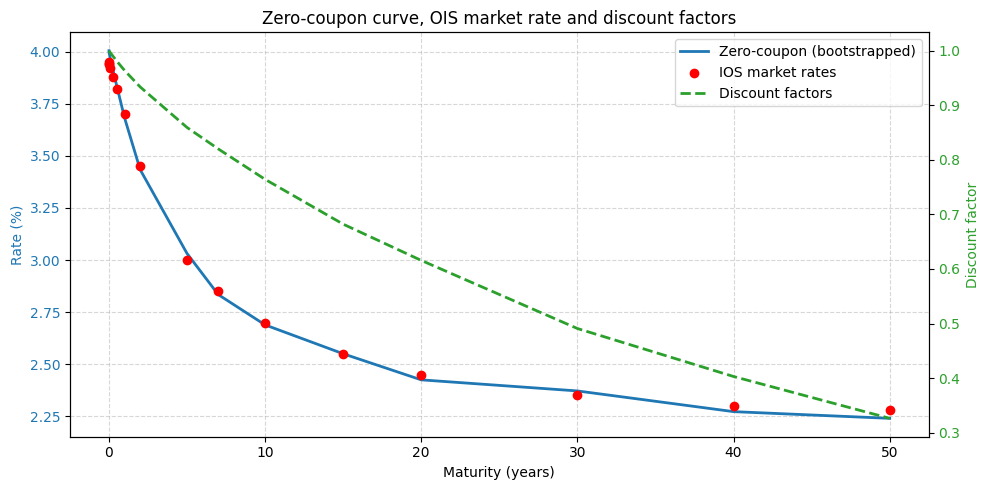

OIS Zero-coupon rates = [(0.0027397260273972603, 0.0400),(0.005479452054794521, 0.0399),(0.019230769230769232, 0.0399),(0.08333333333333333, 0.0397),(0.25, 0.0391),
                         (0.5, 0.0384),(1.0, 0.0368),(2.0, 0.0343),(5.0, 0.0303),(7.0, 0.0283),
                         (10.0, 0.0269),(15.0, 0.0255),(20.0, 0.0242),(30.0, 0.0237),(40.0, 0.0227),
                         (50.0, 0.0224)]


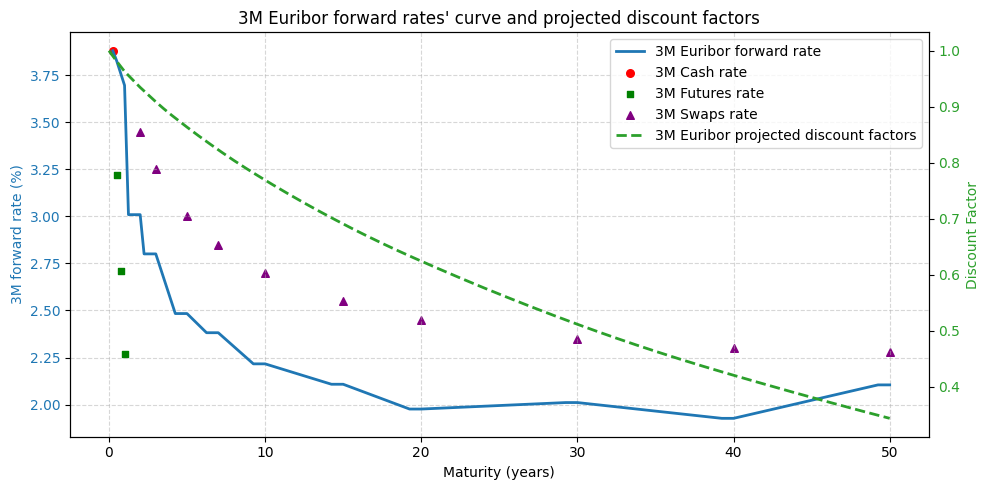

3M_forward_rates = [(0.25, 0.0388),(0.5, 0.0382),(0.75, 0.0376),(1.0, 0.0370),(2.0, 0.0301),
                    (3.0, 0.0280),(4.0, 0.0255),(5.0, 0.0248),(6.0, 0.0240),(7.0, 0.0238),
                    (8.0, 0.0231),(9.0, 0.0223),(10.0, 0.0222),(11.0, 0.0219),(12.0, 0.0217),
                    (13.0, 0.0214),(14.0, 0.0211),(15.0, 0.0211),(20.0, 0.0198),(25.0, 0.0200),
                    (30.0, 0.0201),(40.0, 0.0193),(50.0, 0.0210)]


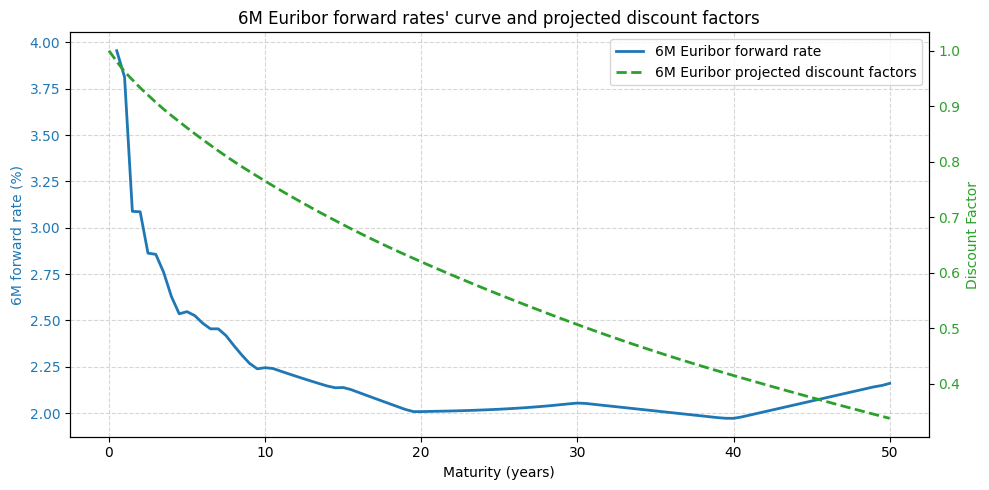

6M_forward_rates = [(0.5, 0.0396),(1.0, 0.0381),(2.0, 0.0309),(3.0, 0.0286),(4.0, 0.0263),
                    (5.0, 0.0255),(6.0, 0.0249),(7.0, 0.0245),(8.0, 0.0236),(9.0, 0.0227),
                    (10.0, 0.0225),(11.0, 0.0223),(12.0, 0.0220),(13.0, 0.0217),(14.0, 0.0215),
                    (15.0, 0.0214),(20.0, 0.0201),(25.0, 0.0202),(30.0, 0.0205),(40.0, 0.0197),
                    (50.0, 0.0216)]


In [51]:
if __name__ == "__main__":
    main()